In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import cvxopt
from cvxopt import matrix, solvers
import cvxopt.solvers
import matplotlib

In [83]:
separable_df = pd.read_csv("linearly-separable-data.csv")
non_separable_df = pd.read_csv("non-separable-data.csv")
non_linearly_separable_df = pd.read_excel("non-linearly-separable-data.xlsx")

<h2>Separable Data</h2>

<AxesSubplot:xlabel='x', ylabel='y'>

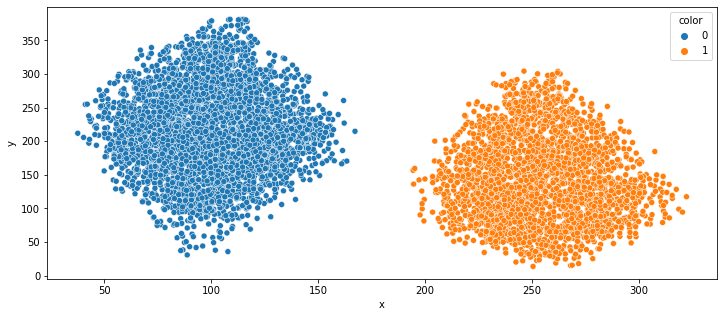

In [84]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x = "x", y = "y", hue = "color", data = separable_df)

<h2>Non-separable Data</h2>

<AxesSubplot:xlabel='x', ylabel='y'>

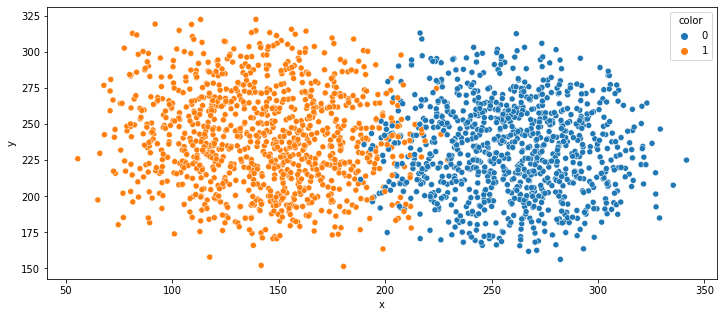

In [85]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x = "x", y = "y", hue = "color", data = non_separable_df)

<h2>Non-linearly separable Data</h2>

<AxesSubplot:xlabel='x', ylabel='y'>

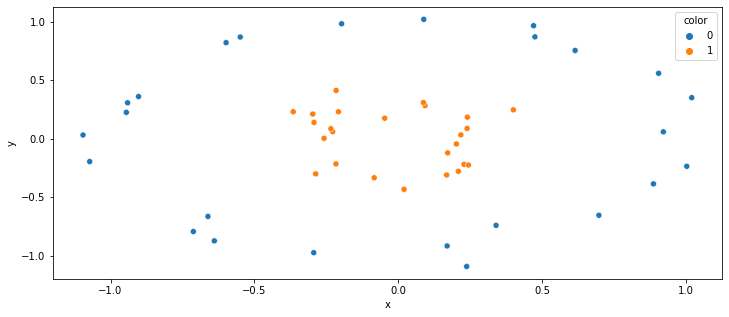

In [86]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x = "x", y = "y", hue = "color", data = non_linearly_separable_df)

<h3>Map the Classes to 1 and -1</h3>

In [87]:
mapping = {0: 1, 1: -1}
separable_df['color'].replace(mapping, inplace= True)
non_separable_df['color'].replace(mapping, inplace= True)
non_linearly_separable_df['color'].replace(mapping, inplace= True)

<h2>Calculate the Loss function:</h2>

- $f(w, b) = \frac{\lVert w \rVert^2}{2}+C\sum_{n=1}^{N}\xi_n$ </br>
- $\xi_n \ge 0$</br>
- $y_n.(w^Tx_n + b) \ge 1-\xi_n$ </br>
$\xi_n \ge 1-[y_n.(w^Tx_n + b)]$

$\xi_n = max(0, 1-[y_n.(w^Tx_n + b)])$

<b>So</b> --> $f(w, b) = \frac{\lVert w \rVert^2}{2}+C[\frac{\sum_{n=1}^{n}max(0,  1-[y_n.(w^Tx_n + b)])}{N}]$ </br>



<h2>Implement the Support Vector Machine class:</h2>

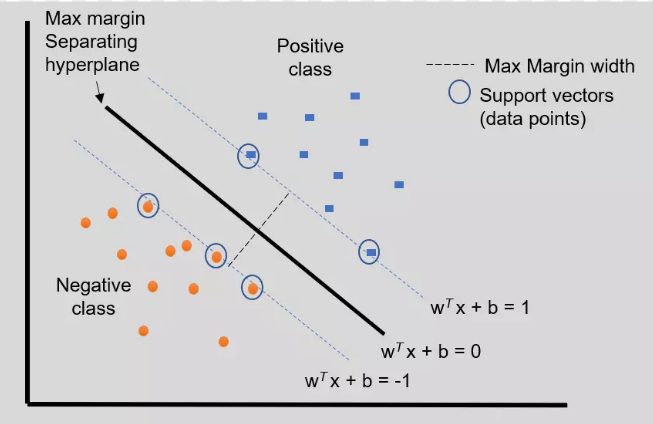

<h3>To Predict:</h3>
If:

$w^Tx + b \ge 1$ then the point is in the positive class </br>
$w^Tx + b \le -1$ then the point is in the negative class

In [88]:
class SVM:
    def __init__(self, kernel="no", C=0):
        self.kernel = kernel
        self.C = C
        

    def train(self, X, y):
        n_samples, n_features = X.shape

        n = X.shape[0]
        H = np.dot(y * X, (y * X).T)
        q = np.repeat([-1.0], n)[..., None]

        A = y.reshape(1, -1).astype(float)
        b = 0.0

        if self.C is None or self.C == 0:
            G = np.negative(np.eye(n))
            h = np.zeros(n)
        else:
            G = matrix(np.vstack((np.eye(n) * -1, np.eye(n))))
            h = matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))

        P = matrix(H)
        q = matrix(q)
        G = matrix(G)
        h = matrix(h)
        A = matrix(A)
        b = matrix(b)

        # solve QP problem
        solution = solvers.qp(P, q, G, h, A, b, kktsolver='ldl', options={'kktreg':1e-9})

        # Lagrange multipliers
        a = np.array(solution["x"])

        self.w = np.dot((y * a).T, X)[0]
        S = (a > 1e-5).flatten()
        self.b = np.mean(y[S] - np.dot(X[S], self.w.reshape(-1, 1)))


    def predict(self, X):
        predicted_color = np.dot(np.transpose(self.w), np.array(X)) + self.b

        if predicted_color < 0:
            return -1
        elif predicted_color > 0:
            return 1
        else:
            return 0

In [89]:
def get_data(filename):
    df = pd.read_csv(filename)
    df = df.head(100)
    df.color = df.color.replace(0, -1)
    X = df[['x', 'y']].to_numpy()  
    y = df['color'].to_numpy().reshape((-1, 1))
    return X, y

In [90]:
def plot_margin(w, X, b, y):
        x_min = X[:, 0].min()-0.1
        x_max = X[:, 0].max()+0.1
        y_min = X[:, 1].min()-0.1
        y_max = X[:, 1].max()+0.1
        xx = np.linspace(x_min, x_max)
        a = -w[0] / w[1]
        yy = a * xx - (b) / w[1]
        margin = 1 / np.sqrt(np.sum(w ** 2))
        yy_neg = yy - np.sqrt(1 + a ** 2) * margin
        yy_pos = yy + np.sqrt(1 + a ** 2) * margin
        plt.figure(figsize=(8, 8))
        plt.plot(xx, yy, "b-")
        plt.plot(xx, yy_neg, "m--")
        plt.plot(xx, yy_pos, "m--")
        colors = ["steelblue", "orange"]
        plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.show()

     pcost       dcost       gap    pres   dres
 0: -8.0144e+00 -1.4495e+01  3e+02  2e+01  2e+00
 1: -9.2681e+00 -4.4580e+00  7e+01  4e+00  5e-01
 2: -2.8872e+01 -7.8977e+00  5e+01  2e+00  3e-01
 3: -4.4858e-01 -8.4617e-03  4e+00  1e-01  2e-02
 4: -5.2465e-03 -1.5601e-03  4e-02  1e-03  2e-04
 5: -3.3367e-04 -1.4256e-03  1e-03  7e-06  9e-07
 6: -9.4480e-04 -1.1130e-03  2e-04  9e-07  1e-07
 7: -1.0562e-03 -1.0994e-03  4e-05  3e-08  3e-09
 8: -1.0942e-03 -1.0947e-03  5e-07  3e-10  3e-11
 9: -1.0946e-03 -1.0946e-03  5e-09  3e-12  3e-13
Optimal solution found.


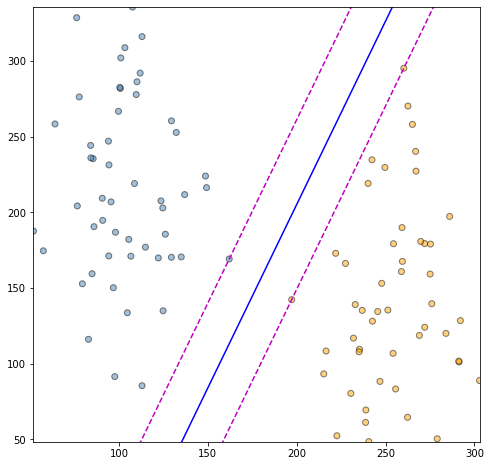

In [91]:
X_lin_sep, y_lin_sep = get_data('linearly-separable-data.csv')
svm = SVM()
svm.train(X_lin_sep, y_lin_sep)
plot_margin(svm.w, X_lin_sep, svm.b, y_lin_sep)

     pcost       dcost       gap    pres   dres
 0: -2.5288e+01 -1.9306e+02  9e+02  2e+00  5e-10
 1: -1.6639e+01 -1.0635e+02  2e+02  3e-01  1e-10
 2: -1.2071e+01 -3.8373e+01  5e+01  9e-02  2e-10
 3: -1.0449e+01 -1.9662e+01  2e+01  3e-02  1e-10
 4: -8.6140e+00 -1.4911e+01  1e+01  2e-02  1e-10
 5: -8.2041e+00 -1.2418e+01  1e+01  1e-02  1e-10
 6: -7.4965e+00 -1.0468e+01  1e+01  1e-02  1e-10
 7: -6.4020e+00 -9.1034e+00  8e+00  7e-03  1e-10
 8: -5.8320e+00 -7.8222e+00  6e+00  5e-03  9e-11
 9: -4.5137e+00 -5.2297e+00  7e-01  9e-10  8e-11
10: -4.8280e+00 -4.9271e+00  1e-01  8e-10  3e-11
11: -4.8536e+00 -4.8572e+00  4e-03  2e-09  2e-11
12: -4.8548e+00 -4.8548e+00  4e-05  1e-09  2e-11
13: -4.8548e+00 -4.8548e+00  4e-07  1e-09  2e-11
Optimal solution found.


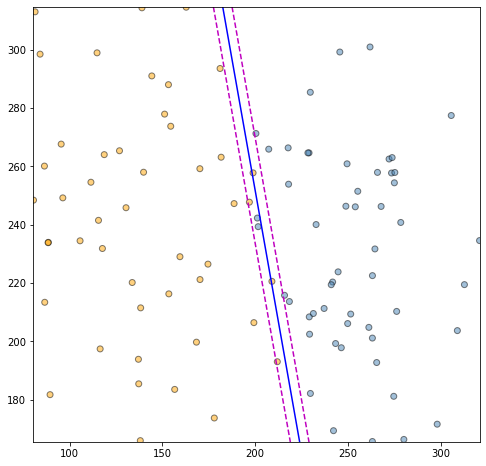

In [92]:
X_non_sep, y_non_sep = get_data('non-separable-data.csv')
svm = SVM(C = 1)
svm.train(X_non_sep, y_non_sep)
plot_margin(svm.w, X_non_sep, svm.b, y_non_sep)